In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
import scipy.stats as st
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import squareform
import networkx as nx
import riskfolio as rp
import riskfolio.RiskFunctions as rk
import riskfolio.AuxFunctions as af
import riskfolio.DBHT as db



In [ ]:
# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
tickers = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
           'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
           'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
tickers.sort()


In [ ]:

# Downloading the data
data = yf.download(tickers, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = tickers
assets = data.pct_change().dropna()

Y = assets

# Creating the Portfolio Object
port = rp.Portfolio(returns=Y)

# To display dataframes values in percentage format
pd.options.display.float_format = '{:.4%}'.format

# Choose the risk measure
rm = 'MSV'  # Semi Standard Deviation


In [ ]:

# Estimate inputs of the model (historical estimates)
method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

In [ ]:
# Estimate the portfolio that maximizes the risk adjusted return ratio
w1 = port.optimization(model='Classic', rm=rm, obj='Sharpe', rf=0.0, l=0, hist=True)

# Estimate points in the efficient frontier mean - semi standard deviation
ws = port.efficient_frontier(model='Classic', rm=rm, points=20, rf=0, hist=True)

# Estimate the risk parity portfolio for semi standard deviation
w2 = port.rp_optimization(model='Classic', rm=rm, rf=0, b=None, hist=True)

### The pearson correlation matrix distance formula

$$f(x) = \sqrt{0.5(1-\rho_{ij})}$$

In [ ]:
def plot_dendrogram(
    returns,
    custom_cov=None,
    codependence="pearson",
    linkage="ward",
    k=None,
    max_k=10,
    bins_info="KN",
    alpha_tail=0.05,
    leaf_order=True,
    title="",
    height=5,
    width=12,
    ax=None,
):
    r"""
    Create a dendrogram based on the selected codependence measure.

    Parameters
    ----------
    returns : DataFrame
        Assets returns.
    custom_cov : DataFrame or None, optional
        Custom covariance matrix, used when codependence parameter has value
        'custom_cov'. The default is None.
    codependence : str, can be {'pearson', 'spearman', 'abs_pearson', 'abs_spearman', 'distance', 'mutual_info', 'tail' or 'custom_cov'}
        The codependence or similarity matrix used to build the distance
        metric and clusters. The default is 'pearson'. Possible values are:

        - 'pearson': pearson correlation matrix. Distance formula: :math:`D_{i,j} = \sqrt{0.5(1-\rho_{i,j})}`.
        - 'spearman': spearman correlation matrix. Distance formula: :math:`D_{i,j} = \sqrt{0.5(1-\rho_{i,j})}`.
        - 'abs_pearson': absolute value pearson correlation matrix. Distance formula: :math:`D_{i,j} = \sqrt{(1-|\rho_{i,j}|)}`.
        - 'abs_spearman': absolute value spearman correlation matrix. Distance formula: :math:`D_{i,j} = \sqrt{(1-|\rho_{i,j}|)}`.
        - 'distance': distance correlation matrix. Distance formula :math:`D_{i,j} = \sqrt{(1-|\rho_{i,j}|)}`.
        - 'mutual_info': mutual information matrix. Distance used is variation information matrix.
        - 'tail': lower tail dependence index matrix. Dissimilarity formula :math:`D_{i,j} = -\log{\lambda_{i,j}}`.
        - 'custom_cov': use custom correlation matrix based on the custom_cov parameter. Distance formula: :math:`D_{i,j} = \sqrt{0.5(1-\rho^{pearson}_{i,j})}`.

    linkage : string, optional
        Linkage method of hierarchical clustering, see `linkage <https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html?highlight=linkage#scipy.cluster.hierarchy.linkage>`_ for more details.
        The default is 'ward'. Possible values are:

        - 'single'.
        - 'complete'.
        - 'average'.
        - 'weighted'.
        - 'centroid'.
        - 'median'.
        - 'ward'.
        - 'DBHT': Direct Bubble Hierarchical Tree.

    k : int, optional
        Number of clusters. This value is took instead of the optimal number
        of clusters calculated with the two difference gap statistic.
        The default is None.
    max_k : int, optional
        Max number of clusters used by the two difference gap statistic
        to find the optimal number of clusters. The default is 10.
    bins_info: int or str
        Number of bins used to calculate variation of information. The default
        value is 'KN'. Possible values are:

        - 'KN': Knuth's choice method. See more in `knuth_bin_width <https://docs.astropy.org/en/stable/api/astropy.stats.knuth_bin_width.html>`_.
        - 'FD': Freedman–Diaconis' choice method. See more in `freedman_bin_width <https://docs.astropy.org/en/stable/api/astropy.stats.freedman_bin_width.html>`_.
        - 'SC': Scotts' choice method. See more in `scott_bin_width <https://docs.astropy.org/en/stable/api/astropy.stats.scott_bin_width.html>`_.
        - 'HGR': Hacine-Gharbi and Ravier' choice method.
        - int: integer value choice by user.

    alpha_tail : float, optional
        Significance level for lower tail dependence index. The default is 0.05.
    leaf_order : bool, optional
        Indicates if the cluster are ordered so that the distance between
        successive leaves is minimal. The default is True.
    title : str, optional
        Title of the chart. The default is "".
    height : float, optional
        Height of the image in inches. The default is 5.
    width : float, optional
        Width of the image in inches. The default is 12.
    ax : matplotlib axis, optional
        If provided, plot on this axis. The default is None.

    Raises
    ------
    ValueError
        When the value cannot be calculated.

    Returns
    -------
    ax : matplotlib axis
        Returns the Axes object with the plot for further tweaking.

    Example
    -------
    ::

        ax = rp.plot_dendrogram(returns=Y, correlation='spearman',
                                linkage='ward', k=None, max_k=10,
                                leaf_order=True, ax=None)

    .. image:: images/Assets_Dendrogram.png


    """
    if not isinstance(returns, pd.DataFrame):
        raise ValueError("returns must be a DataFrame")

    if ax is None:
        fig = plt.gcf()
        ax = fig.gca()
        fig.set_figwidth(width)
        fig.set_figheight(height)
    else:
        fig = ax.get_figure()

    labels = np.array(returns.columns.tolist())

    # Calculating codependence matrix and distance metric
    if codependence in {"pearson", "spearman"}:
        codep = returns.corr(method=codependence)
        dist = np.sqrt(np.clip((1 - codep) / 2, a_min=0.0, a_max=1.0))
    elif codependence in {"abs_pearson", "abs_spearman"}:
        codep = np.abs(returns.corr(method=codependence[4:]))
        dist = np.sqrt(np.clip((1 - codep), a_min=0.0, a_max=1.0))
    elif codependence in {"distance"}:
        codep = af.dcorr_matrix(returns).astype(float)
        dist = np.sqrt(np.clip((1 - codep), a_min=0.0, a_max=1.0))
    elif codependence in {"mutual_info"}:
        codep = af.mutual_info_matrix(returns, bins_info).astype(float)
        dist = af.var_info_matrix(returns, bins_info).astype(float)
    elif codependence in {"tail"}:
        codep = af.ltdi_matrix(returns, alpha_tail).astype(float)
        dist = -np.log(codep)
    elif codependence in {"custom_cov"}:
        codep = af.cov2corr(custom_cov).astype(float)
        dist = np.sqrt(np.clip((1 - codep) / 2, a_min=0.0, a_max=1.0))

    # Hierarchcial clustering
    dist = dist.to_numpy()
    dist = pd.DataFrame(dist, columns=codep.columns, index=codep.index)
    if linkage == "DBHT":
        # different choices for D, S give different outputs!
        D = dist.to_numpy()  # dissimilatity matrix
        if codependence in {"pearson", "spearman", "custom_cov"}:
            S = (1 - dist**2).to_numpy()
        else:
            S = codep.copy().to_numpy()  # similarity matrix
        (_, _, _, _, _, clustering) = db.DBHTs(
            D, S, leaf_order=leaf_order
        )  # DBHT clustering
    else:
        p_dist = squareform(dist, checks=False)
        clustering = hr.linkage(p_dist, method=linkage, optimal_ordering=leaf_order)

    # Ordering clusterings
    permutation = hr.leaves_list(clustering)
    permutation = permutation.tolist()

    # optimal number of clusters
    if k is None:
        k = af.two_diff_gap_stat(codep, dist, clustering, max_k)

    root, nodes = hr.to_tree(clustering, rd=True)
    nodes = [i.dist for i in nodes]
    nodes.sort()
    nodes = nodes[::-1][: k - 1]
    color_threshold = np.min(nodes)

    colors = af.color_list(k)  # color list

    hr.set_link_color_palette(colors)
    hr.dendrogram(
        clustering, color_threshold=color_threshold, above_threshold_color="grey", ax=ax
    )
    hr.set_link_color_palette(None)

    ax.set_xticklabels(labels[permutation], rotation=90, ha="center")

    i = 0
    for coll in ax.collections[:-1]:  # the last collection is the ungrouped level
        xmin, xmax = np.inf, -np.inf
        ymax = -np.inf
        for p in coll.get_paths():
            (x0, _), (x1, y1) = p.get_extents().get_points()
            xmin = min(xmin, x0)
            xmax = max(xmax, x1)
            ymax = max(ymax, y1)
        rec = plt.Rectangle(
            (xmin - 4, 0),
            xmax - xmin + 8,
            ymax * 1.05,
            facecolor=colors[i],  # coll.get_color()[0],
            alpha=0.2,
            edgecolor="none",
        )
        ax.add_patch(rec)
        i += 1

    ax.set_yticks([])
    ax.set_yticklabels([])
    for i in {"right", "left", "top", "bottom"}:
        side = ax.spines[i]
        side.set_visible(False)

    if title == "":
        title = (
            "Assets Dendrogram ("
            + codependence.capitalize()
            + " & "
            + linkage
            + " linkage)"
        )

    ax.set_title(title)

    try:
        fig.tight_layout()
    except:
        pass

    return ax


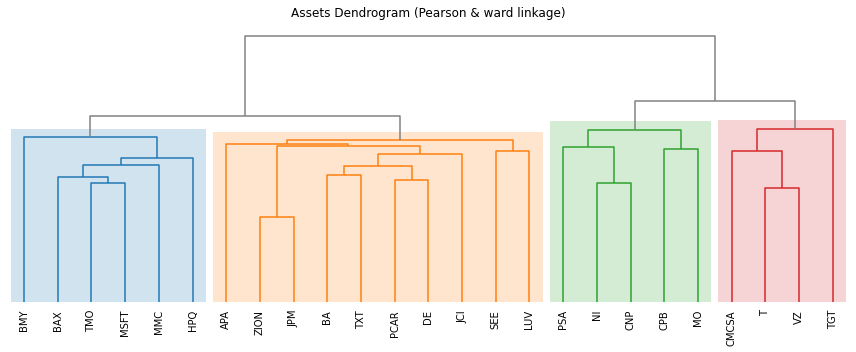

In [40]:
ax = plot_dendrogram(returns=Y,
                        codependence='pearson',
                        linkage='ward',
                        k=None,
                        max_k=10,
                        leaf_order=True,
                        ax=None)

### Create a network plot. The Planar Maximally Filtered Graph (PMFG) for DBHT linkage and Minimum Spanning Tree (MST) for other linkage methods.

In [ ]:
def plot_network(
    returns,
    custom_cov=None,
    codependence="pearson",
    linkage="ward",
    k=None,
    max_k=10,
    bins_info="KN",
    alpha_tail=0.05,
    leaf_order=True,
    kind="spring",
    seed=0,
    node_labels=True,
    node_size=1400,
    node_alpha=0.7,
    font_size=10,
    title="",
    height=8,
    width=10,
    ax=None,
):
    r"""
    Create a network plot. The Planar Maximally Filtered Graph (PMFG) for DBHT
    linkage and Minimum Spanning Tree (MST) for other linkage methods.

    Parameters
    ----------
    returns : DataFrame
        Assets returns.
    custom_cov : DataFrame or None, optional
        Custom covariance matrix, used when codependence parameter has value
        'custom_cov'. The default is None.
    codependence : str, can be {'pearson', 'spearman', 'abs_pearson', 'abs_spearman', 'distance', 'mutual_info', 'tail' or 'custom_cov'}
        The codependence or similarity matrix used to build the distance
        metric and clusters. The default is 'pearson'. Possible values are:

        - 'pearson': pearson correlation matrix. Distance formula: :math:`D_{i,j} = \sqrt{0.5(1-\rho^{pearson}_{i,j})}`.
        - 'spearman': spearman correlation matrix. Distance formula: :math:`D_{i,j} = \sqrt{0.5(1-\rho^{spearman}_{i,j})}`.
        - 'abs_pearson': absolute value pearson correlation matrix. Distance formula: :math:`D_{i,j} = \sqrt{(1-|\rho^{pearson}_{i,j}|)}`.
        - 'abs_spearman': absolute value spearman correlation matrix. Distance formula: :math:`D_{i,j} = \sqrt{(1-|\rho^{spearman}_{i,j}|)}`.
        - 'distance': distance correlation matrix. Distance formula :math:`D_{i,j} = \sqrt{(1-\rho^{distance}_{i,j})}`.
        - 'mutual_info': mutual information matrix. Distance used is variation information matrix.
        - 'tail': lower tail dependence index matrix. Dissimilarity formula :math:`D_{i,j} = -\log{\lambda_{i,j}}`.
        - 'custom_cov': use custom correlation matrix based on the custom_cov parameter. Distance formula: :math:`D_{i,j} = \sqrt{0.5(1-\rho^{pearson}_{i,j})}`.

    linkage : string, optional
        Linkage method of hierarchical clustering, see `linkage <https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html?highlight=linkage#scipy.cluster.hierarchy.linkage>`_ for more details.
        The default is 'ward'. Possible values are:

        - 'single'.
        - 'complete'.
        - 'average'.
        - 'weighted'.
        - 'centroid'.
        - 'median'.
        - 'ward'.
        - 'DBHT': Direct Bubble Hierarchical Tree.

    k : int, optional
        Number of clusters. This value is took instead of the optimal number
        of clusters calculated with the two difference gap statistic.
        The default is None.
    max_k : int, optional
        Max number of clusters used by the two difference gap statistic
        to find the optimal number of clusters. The default is 10.
    bins_info: int or str
        Number of bins used to calculate variation of information. The default
        value is 'KN'. Possible values are:

        - 'KN': Knuth's choice method. See more in `knuth_bin_width <https://docs.astropy.org/en/stable/api/astropy.stats.knuth_bin_width.html>`_.
        - 'FD': Freedman–Diaconis' choice method. See more in `freedman_bin_width <https://docs.astropy.org/en/stable/api/astropy.stats.freedman_bin_width.html>`_.
        - 'SC': Scotts' choice method. See more in `scott_bin_width <https://docs.astropy.org/en/stable/api/astropy.stats.scott_bin_width.html>`_.
        - 'HGR': Hacine-Gharbi and Ravier' choice method.
        - int: integer value choice by user.

    alpha_tail : float, optional
        Significance level for lower tail dependence index. The default is 0.05.
    leaf_order : bool, optional
        Indicates if the cluster are ordered so that the distance between
        successive leaves is minimal. The default is True.
    kind : str, optional
        Kind of networkx layout. The default value is 'spring'. Possible values
        are:

        - 'spring': networkx spring_layout.
        - 'planar'. networkx planar_layout.
        - 'circular'. networkx circular_layout.
        - 'kamada'. networkx kamada_kawai_layout. Only available for positive codependence metrics. Not pearson or spearman except when linkage is DBHT.

    seed : int, optional
        Seed for networkx spring layout. The default value is 0.
    node_labels : bool, optional
        Specify if node lables are visible. The default value is True.
    node_size : float, optional
        Size of the nodes. The default value is 1600.
    node_alpha : float, optional
        Alpha parameter or transparency of nodes. The default value is 0.7.
    font_size : float, optional
        Font size of node labels. The default value is 12.
    title : str, optional
        Title of the chart. The default is "".
    height : float, optional
        Height of the image in inches. The default is 5.
    width : float, optional
        Width of the image in inches. The default is 12.
    ax : matplotlib axis, optional
        If provided, plot on this axis. The default is None.

    Raises
    ------
    ValueError
        When the value cannot be calculated.

    Returns
    -------
    ax : matplotlib axis
        Returns the Axes object with the plot for further tweaking.

    Example
    -------
    ::

        ax = rp.plot_network(returns=Y, codependence="pearson",
                             linkage="ward", k=None, max_k=10,
                             alpha_tail=0.05, leaf_order=True,
                             kind='spring', ax=None)


    .. image:: images/Assets_Network.png


    """
    if not isinstance(returns, pd.DataFrame):
        raise ValueError("returns must be a DataFrame")

    if ax is None:
        fig = plt.gcf()
        ax = fig.gca()
        fig.set_figwidth(width)
        fig.set_figheight(height)
    else:
        fig = ax.get_figure()

    labels = np.array(returns.columns.tolist())

    # Calculating codependence matrix and distance metric
    if codependence in {"pearson", "spearman"}:
        codep = returns.corr(method=codependence)
        dist = np.sqrt(np.clip((1 - codep) / 2, a_min=0.0, a_max=1.0))
    elif codependence in {"abs_pearson", "abs_spearman"}:
        codep = np.abs(returns.corr(method=codependence[4:]))
        dist = np.sqrt(np.clip((1 - codep), a_min=0.0, a_max=1.0))
    elif codependence in {"distance"}:
        codep = af.dcorr_matrix(returns).astype(float)
        dist = np.sqrt(np.clip((1 - codep), a_min=0.0, a_max=1.0))
    elif codependence in {"mutual_info"}:
        codep = af.mutual_info_matrix(returns, bins_info).astype(float)
        dist = af.var_info_matrix(returns, bins_info).astype(float)
    elif codependence in {"tail"}:
        codep = af.ltdi_matrix(returns, alpha_tail).astype(float)
        dist = -np.log(codep)
    elif codependence in {"custom_cov"}:
        codep = af.cov2corr(custom_cov).astype(float)
        dist = np.sqrt(np.clip((1 - codep) / 2, a_min=0.0, a_max=1.0))

    # Hierarchcial clustering
    dist = dist.to_numpy()
    dist = pd.DataFrame(dist, columns=codep.columns, index=codep.index)
    if linkage == "DBHT":
        # different choices for D, S give different outputs!
        D = dist.to_numpy()  # dissimilatity matrix
        if codependence in {"pearson", "spearman", "custom_cov"}:
            S = (1 - dist**2).to_numpy()
        else:
            S = codep.copy().to_numpy()  # similarity matrix
        (_, Rpm, _, _, _, clustering) = db.DBHTs(
            D, S, leaf_order=leaf_order
        )  # DBHT clustering
        MAdj = pd.DataFrame(Rpm, index=labels, columns=labels)
        G = nx.from_pandas_adjacency(MAdj)
    else:
        p_dist = squareform(dist, checks=False)
        clustering = hr.linkage(p_dist, method=linkage, optimal_ordering=leaf_order)
        T = nx.from_pandas_adjacency(codep)  # create a graph G from a numpy matrix
        G = nx.minimum_spanning_tree(T)

    # optimal number of clusters
    if k is None:
        k = af.two_diff_gap_stat(codep, dist, clustering, max_k)

    clustering_inds = hr.fcluster(clustering, k, criterion="maxclust")
    clusters = {i: [] for i in range(min(clustering_inds), max(clustering_inds) + 1)}
    for i, v in enumerate(clustering_inds):
        clusters[v].append(labels[i])

    # Layout options
    node_options = {
        "node_size": node_size,
        "alpha": node_alpha,
    }
    font_options = {
        "font_size": font_size,
        "font_color": "k",
    }

    label_options = {"ec": "k", "fc": "white", "alpha": 0.7}

    if kind == "spring":
        pos = nx.spring_layout(G, seed=seed)
    elif kind == "planar":
        pos = nx.planar_layout(G)
    elif kind == "circular":
        pos = nx.circular_layout(G)
    elif kind == "kamada":
        if codependence in {"pearson", "spearman"} and linkage != "DBHT":
            raise NameError(
                "kamada layout only works with positive codependence measures except when linkage is DBHT."
            )
        pos = nx.kamada_kawai_layout(G)

    # Plotting
    nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color="grey")

    if node_labels == True:
        nx.draw_networkx_labels(G, pos=pos, ax=ax, bbox=label_options, **font_options)

    colors = af.color_list(k)

    for i, color in zip(clusters.keys(), colors):
        nx.draw_networkx_nodes(
            G, pos=pos, nodelist=clusters[i], node_color=color, ax=ax, **node_options
        )

    ax.set_yticks([])
    ax.set_yticklabels([])
    for i in {"right", "left", "top", "bottom"}:
        side = ax.spines[i]
        side.set_visible(False)

    if title == "":
        if linkage == "DBHT":
            title = (
                "Planar Maximally Filtered Graph ("
                + codependence.capitalize()
                + ", "
                + linkage
                + " linkage & "
                + kind
                + " layout)"
            )
        else:
            title = (
                "Minimun Spanning Tree ("
                + codependence.capitalize()
                + ", "
                + linkage
                + " linkage & "
                + kind
                + " layout)"
            )

    ax.set_title(title)

    try:
        fig.tight_layout()
    except:
        pass

    return ax


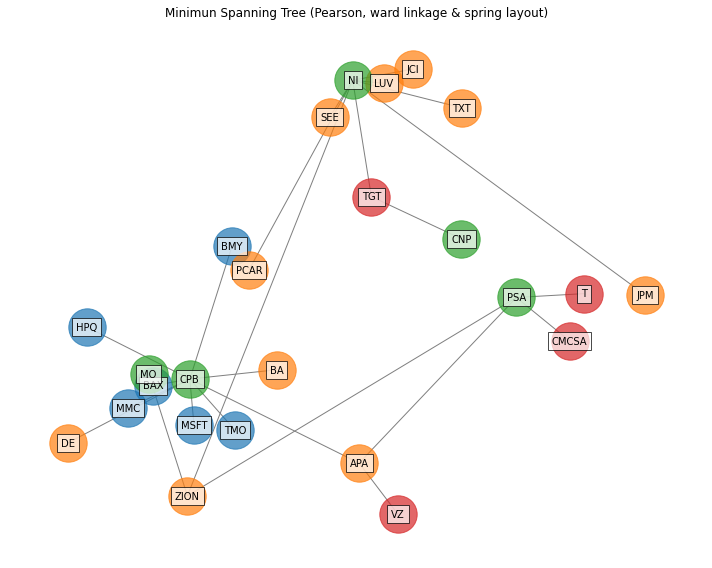

In [41]:
ax = plot_network(returns=Y, codependence="pearson",
                     linkage="ward", k=None, max_k=10,
                     alpha_tail=0.05, leaf_order=True,
                     kind='spring', ax=None)
